In [1]:
import uproot
import numpy as np
import awkward as ak

import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

from scipy.optimize import curve_fit
from scipy.stats import binned_statistic

mpl.rc('image', cmap='Purples')
plt.style.use(hep.style.CMS)

In [2]:
from scipy.stats import norm

gauss_pdf = lambda x, mu, k, s: k * norm.pdf(x, mu, s)
gauss2_pdf = lambda x, m1, k1, s1, m2, k2, s2: gauss_pdf(x, m1, k1, s1) + gauss_pdf(x, m2, k2, s2)

In [3]:
f = uproot.open("/home/work/gem/testbeam/may2022/tracks/00000135_full.root")
f.keys()

['trackTree;1244', 'trackTree;1243']

In [4]:
t = f["trackTree"]
t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
orbitNumber          | int32_t                  | AsDtype('>i4')
bunchCounter         | int32_t                  | AsDtype('>i4')
eventCounter         | int32_t                  | AsDtype('>i4')
rechitDigiStrip      | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
rechitRawChannel     | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
rechitChamber        | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
rechitEta            | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitLocalX         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitLocalY         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitR              | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitPhi            | std::vector<double>      | AsJagged(AsDtype('>f8'), h

In [5]:
events = t.arrays(
    [
        "rechitChamber", "rechitEta",
        "rechitLocalX", "rechitLocalY", "rechitClusterSize",
        "rechitR", "rechitPhi",
        "prophitChamber", "trackChi2",
        "prophitLocalX", "prophitLocalY",
        "prophitGlobalX", "prophitGlobalY",
        "prophitR", "prophitPhi"
    ], entry_stop=2000000
)

In [6]:
rechits_chamber = events["rechitChamber"]
rechits_eta = events["rechitEta"]
rechits_cluster_size = events["rechitClusterSize"]
rechits_x = events["rechitLocalX"]
rechits_y = events["rechitLocalY"]
rechits_r = events["rechitR"]
rechits_phi = events["rechitPhi"]

print(rechits_chamber, ak.count(rechits_chamber, axis=1))
print(rechits_x, ak.count(rechits_x, axis=1))
print(rechits_y, ak.count(rechits_y, axis=1))

[[0, 1, 2, 3, 4, 5, 8, 9, 10], [0, 1, 2, ... 9, 10], [0, 1, 2, 3, 4, 5, 8, 8, 9, 10]] [9, 8, 9, 10, 7, 9, 4, 7, 8, 9, 2, 8, 9, ... 8, 3, 7, 8, 8, 12, 10, 7, 7, 10, 7, 10]
[[41.6, -19.1, 42.4, -23.8, 42.1, -27.8, ... 12.1, 4.12, 120, 112, -31.6, -38.2]] [9, 8, 9, 10, 7, 9, 4, 7, 8, 9, 2, 8, 9, ... 8, 3, 7, 8, 8, 12, 10, 7, 7, 10, 7, 10]
[[0, 0, 0, 0, 0, 0, 48.9, 246, 246], ... 0, 0, 0, 0, 0, 0, -48.9, -48.9, 246, 246]] [9, 8, 9, 10, 7, 9, 4, 7, 8, 9, 2, 8, 9, ... 8, 3, 7, 8, 8, 12, 10, 7, 7, 10, 7, 10]


In [7]:
prophits_chamber = events["prophitChamber"]
prophits_x = events["prophitLocalX"]
prophits_y = events["prophitLocalY"]
prophits_r = events["prophitR"]
prophits_phi = events["prophitPhi"]

print(prophits_chamber, ak.count(prophits_chamber, axis=1))
print(prophits_x, ak.count(prophits_x, axis=1))
print(prophits_y, ak.count(prophits_y, axis=1))

[[8, 9, 10], [8, 9, 10], [8, 9, 10], [8, ... 10], [8, 9, 10], [8, 9, 10], [8, 9, 10]] [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ... 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[[42.9, -9.06, -17.9], [-13, 9.69, 0.997, ... 1.79, -6.9], [12.9, -40.7, -49.4]] [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ... 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[[27.6, 556, 560], [46.4, 612, 616], [29, ... [38.4, 614, 619], [-4.01, 586, 591]] [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ... 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [8]:
tested_chamber = 9

rechits_eta_chamber = rechits_eta[rechits_chamber==tested_chamber]
rechits_cluster_size_chamber = rechits_cluster_size[rechits_chamber==tested_chamber]
rechits_x_chamber = rechits_x[rechits_chamber==tested_chamber]
rechits_y_chamber = rechits_y[rechits_chamber==tested_chamber]
rechits_r_chamber = rechits_r[rechits_chamber==tested_chamber]
rechits_phi_chamber = rechits_phi[rechits_chamber==tested_chamber]
prophits_global_x_chamber = events["prophitGlobalX"][prophits_chamber==tested_chamber]
prophits_global_y_chamber = events["prophitGlobalY"][prophits_chamber==tested_chamber]
prophits_x_chamber = prophits_x[prophits_chamber==tested_chamber]
prophits_y_chamber = prophits_y[prophits_chamber==tested_chamber]
prophits_r_chamber = prophits_r[prophits_chamber==tested_chamber]
prophits_phi_chamber = prophits_phi[prophits_chamber==tested_chamber]

print("Eta", rechits_eta_chamber)
print("Rechit x", rechits_x_chamber)
print("Rechit cluster size", rechits_cluster_size_chamber)
print("Rechit y", rechits_y_chamber)
print("Rechit r", rechits_r_chamber)
print(rechits_r_chamber - rechits_y_chamber)
print("Prophit x", prophits_x_chamber)
print("Prophit y", prophits_y_chamber)
print("Prophit r", prophits_r_chamber)
print(prophits_r_chamber - prophits_y_chamber)

Eta [[2], [2], [2], [2], [2], [2], [2], [2, ... 2], [2, 2], [2], [2], [2, 2], [2], [2]]
Rechit x [[-6.22], [7.56], [-5.78], [-52.9], ... [2.67], [-30.2, -28.4], [1.33], [-31.6]]
Rechit cluster size [[1], [2], [2], [2], [3], [2], [2], [1, ... 2], [4, 1], [1], [3], [1, 1], [2], [2]]
Rechit y [[246], [246], [246], [246], [246], [246, ... [246], [246], [246, 246], [246], [246]]
Rechit r [[1.19e+03], [1.19e+03], [1.19e+03], ... 1.19e+03, 1.19e+03], [1.19e+03], [1.19e+03]]
[[940], [940], [940], [941], [940], [940, ... [940], [940], [940, 940], [940], [940]]
Prophit x [[-9.06], [9.69], [-7.63], [-67.2], [5.96, ... [2.85], [-38.3], [1.79], [-40.7]]
Prophit y [[556], [612], [592], [577], [626], [581, ... [628], [605], [630], [614], [586]]
Prophit r [[1.5e+03], [1.55e+03], [1.53e+03], ... [1.57e+03], [1.55e+03], [1.53e+03]]
[[940], [940], [940], [941], [940], [940, ... [940], [940], [940], [940], [940]]


In [104]:
"""
Create local coordinates for propagated hits
"""

x0_iterations = [599.2500084590041+1.1297863110751836]
y0_iterations = [36.852998674788246+0.026180799819145385-0.20745277879580715]
theta_iterations = [1.57110714139590-0.0003768236224281511]

"""x0_iterations = [
    246.25,284.77713036305266,75.6968342353971,2.3221865013796847,0.042240235936660264,-5.716764427841607,
    -5.07908636174257,0.9574679128221383
]
y0_iterations = [
    12.804288440398453,16.433990559590807,16.75950207603541,0.6788712866114323,-8.252559009093847,
    -1.5710946787540159
]
theta_iterations = [
    0.7058545286143754,0.4208163951153983,0.1870225593151079,0.08172960039697114,0.03885225342174877,
    0.043377271309232746,0.06627287763846362,0.027690579656812896,0.000993237437897869,0.00034827906342919213,
    -1.622671949368258e-05,-0.0018342138540351546
]"""
x0 = sum(x0_iterations)
y0 = sum(y0_iterations)
theta = sum(theta_iterations)
c, s = np.cos(theta), np.sin(theta)
Y_ORIGIN = -939.633

prophits_x_chamber = (prophits_global_x_chamber-x0) * c + (prophits_global_y_chamber-y0) * s
prophits_y_chamber = -(prophits_global_x_chamber-x0) * s + (prophits_global_y_chamber-y0) * c
prophits_r_chamber = np.sqrt(prophits_x_chamber**2 + (prophits_y_chamber-Y_ORIGIN)**2)
prophits_phi_chamber = np.arctan(prophits_x_chamber/(prophits_y_chamber-Y_ORIGIN))

print("x0", x0)
print("y0", y0)
print("theta", theta)

x0 600.3797947700793
y0 36.671726695811586
theta 1.5707303177734717


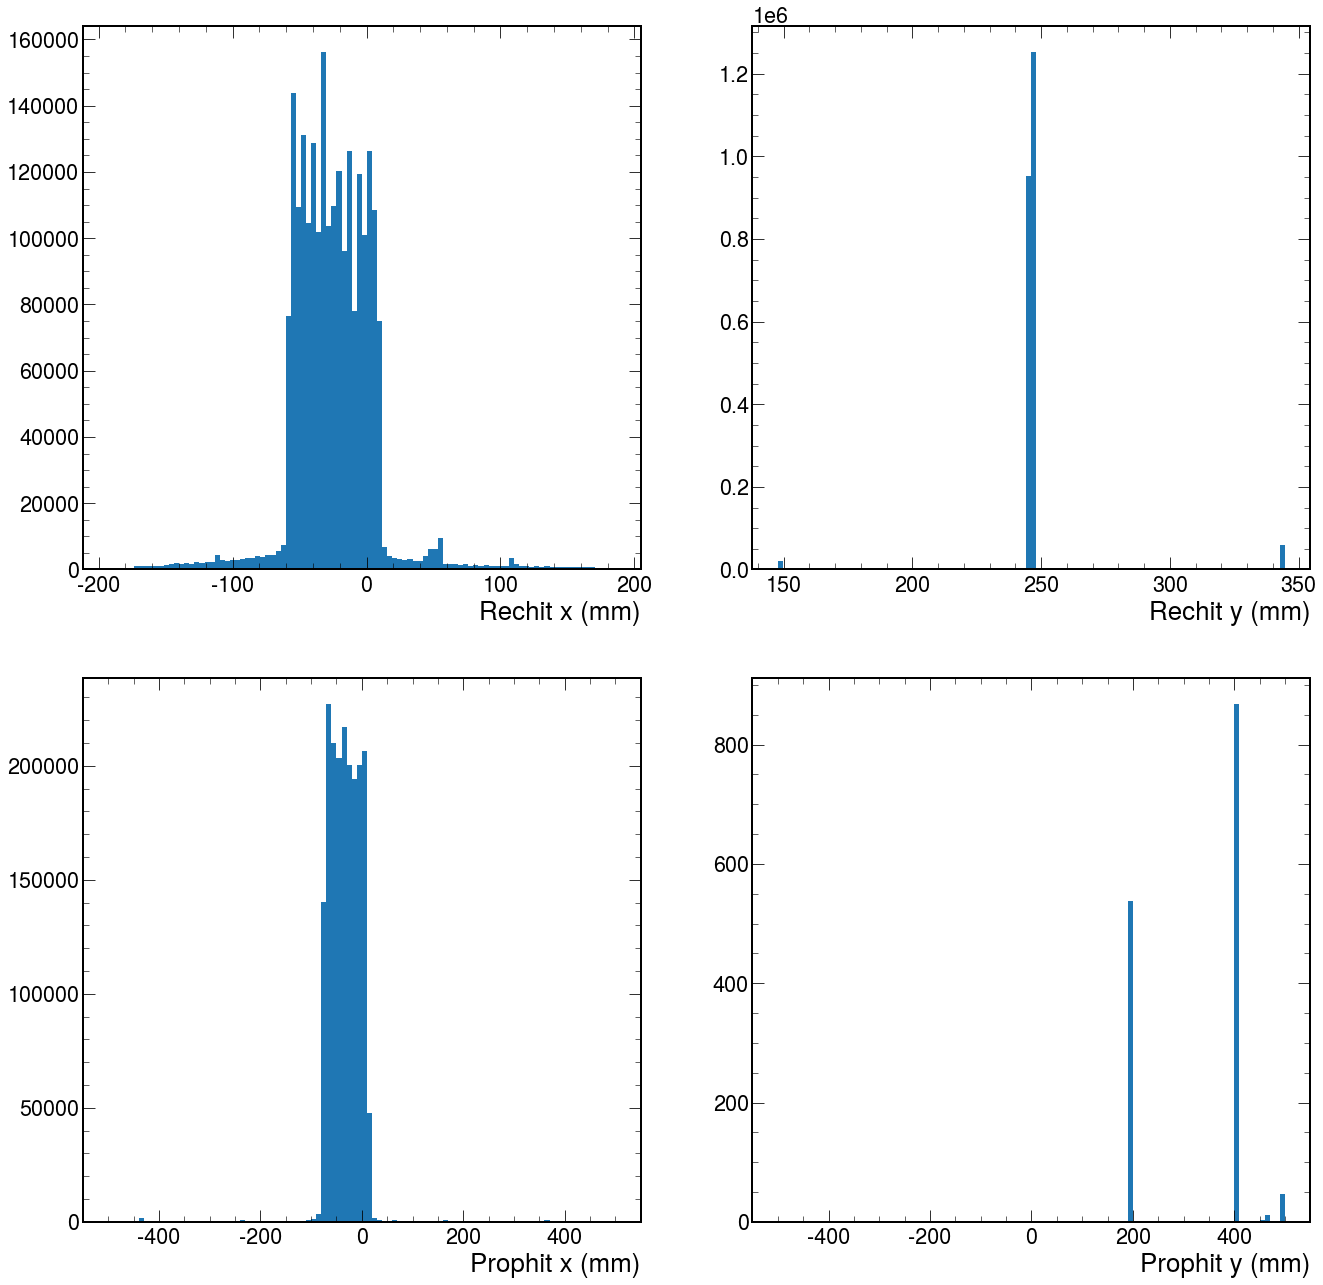

In [105]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,22))
_ = ax[0][0].hist(ak.flatten(rechits_x_chamber), bins=100)#, range=(-50,50))
_ = ax[0][1].hist(ak.flatten(rechits_y_chamber), bins=100)#, range=(-50,50))
_ = ax[1][0].hist(ak.flatten(prophits_x_chamber), bins=100, range=(-500,500))
_ = ax[1][1].hist(ak.flatten(prophits_y_chamber), bins=100, range=(-500,500))

_ = ax[0][0].set_xlabel("Rechit x (mm)")
_ = ax[0][1].set_xlabel("Rechit y (mm)")
_ = ax[1][0].set_xlabel("Prophit x (mm)")
_ = ax[1][1].set_xlabel("Prophit y (mm)")

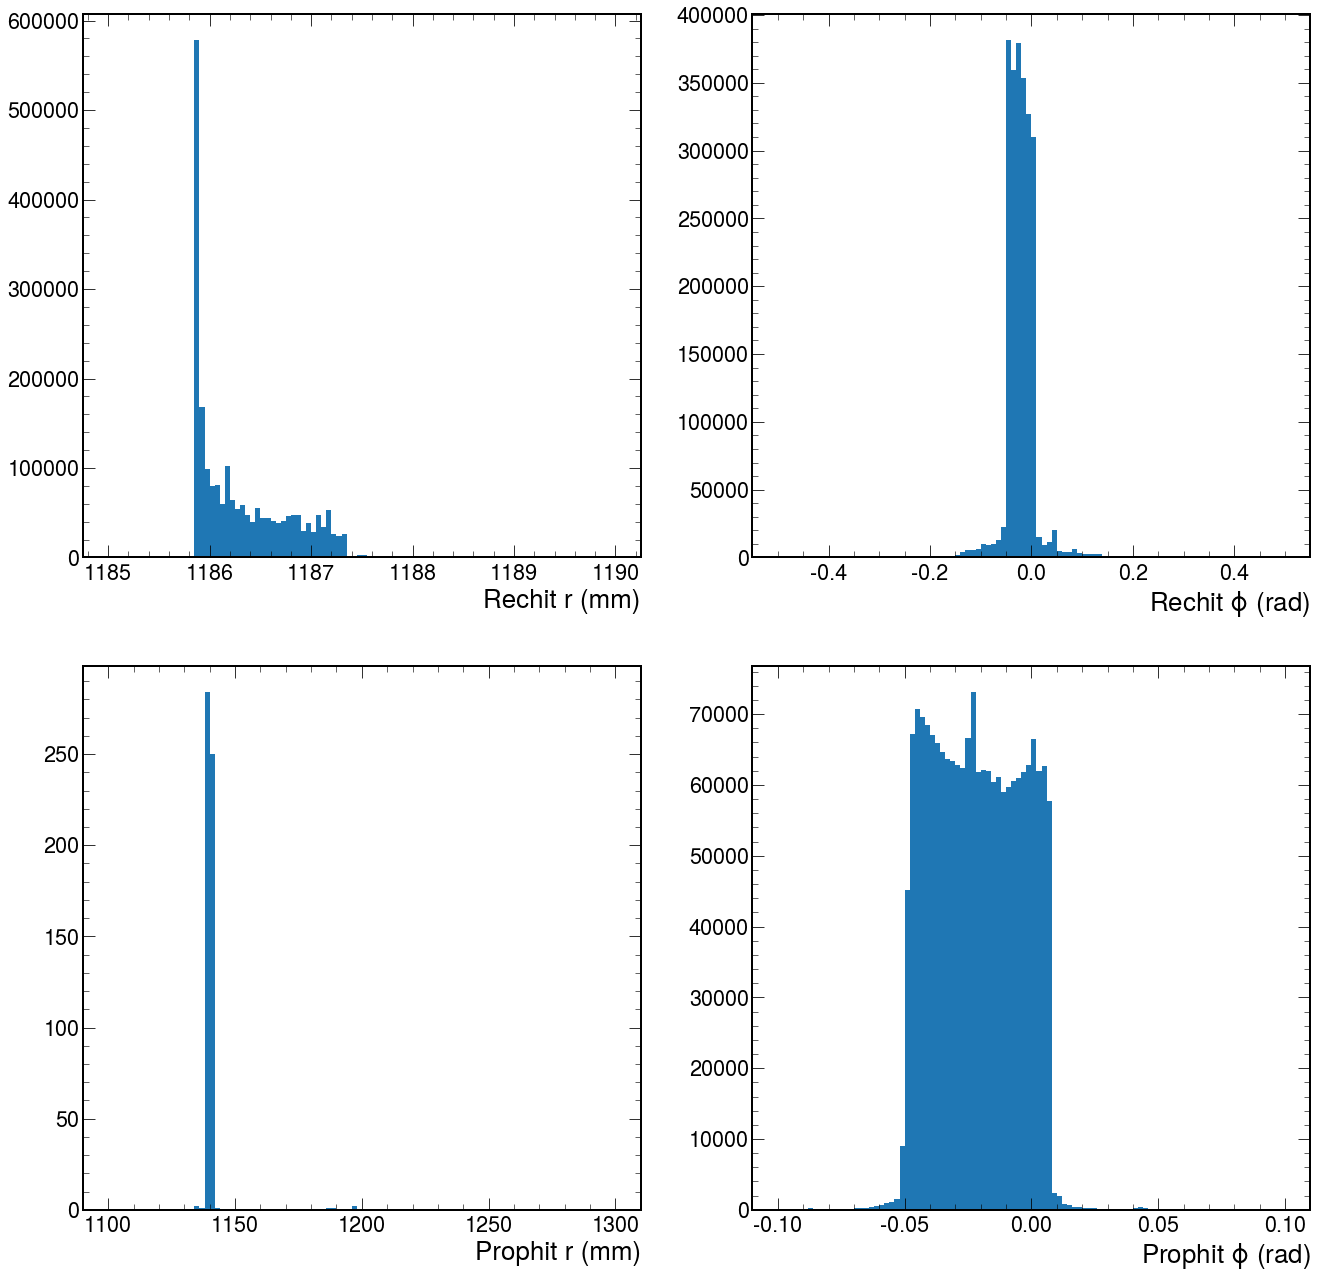

In [106]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,22))
_ = ax[0][0].hist(ak.flatten(rechits_r_chamber), bins=100, range=(1185,1190))
_ = ax[0][1].hist(ak.flatten(rechits_phi_chamber), bins=100, range=(-0.5,0.5))
_ = ax[1][0].hist(ak.flatten(prophits_r_chamber), bins=100, range=(1100,1300))
_ = ax[1][1].hist(ak.flatten(prophits_phi_chamber), bins=100, range=(-0.1,0.1))

_ = ax[0][0].set_xlabel("Rechit r (mm)")
_ = ax[0][1].set_xlabel("Rechit $\phi$ (rad)")
_ = ax[1][0].set_xlabel("Prophit r (mm)")
_ = ax[1][1].set_xlabel("Prophit $\phi$ (rad)")

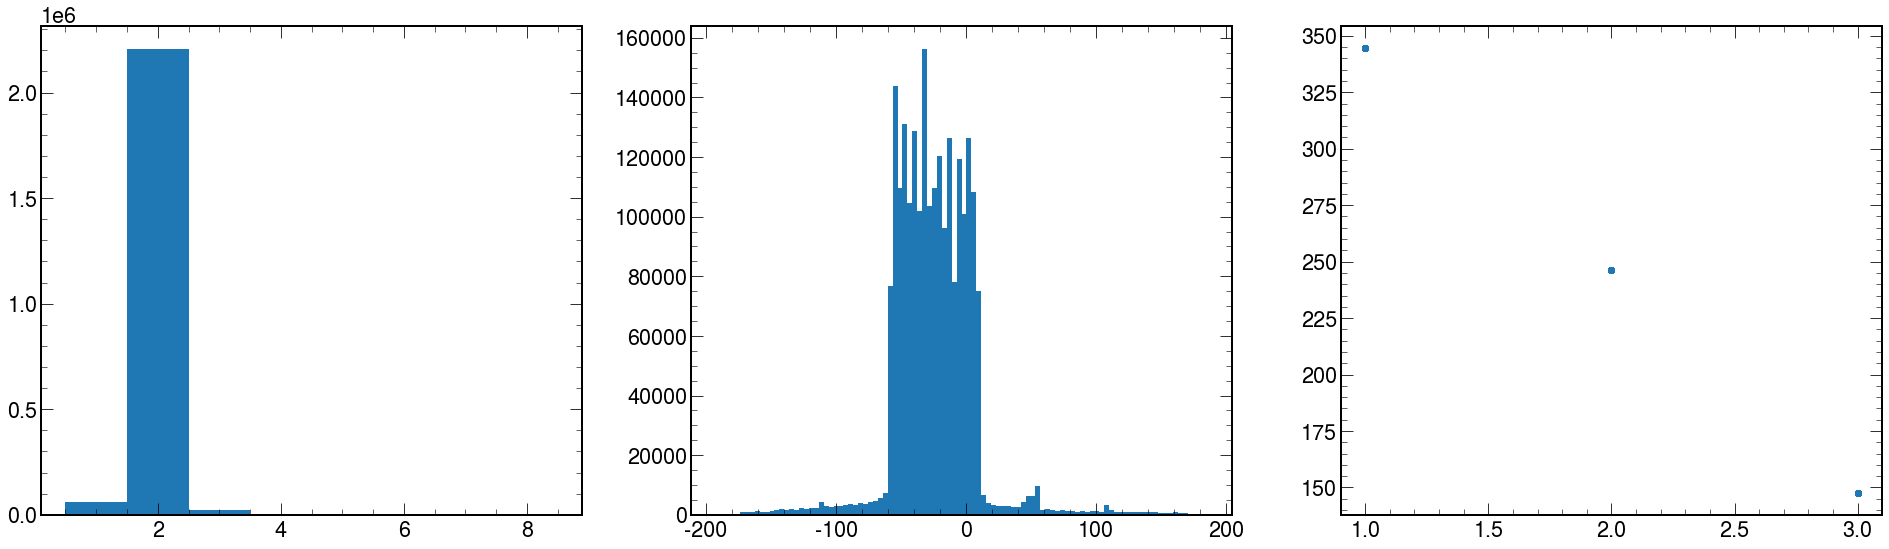

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(33,9))
_ = ax[0].hist(ak.flatten(rechits_eta_chamber), bins=8, range=(0.5, 8.5))
_ = ax[1].hist(ak.flatten(rechits_x_chamber), bins=100)#, range=(-50,50))
_ = ax[2].scatter(
    ak.flatten(rechits_eta_chamber), ak.flatten(rechits_y_chamber),
    #bins=(8,8), range=((0.5,8.5),(-400,400))
)

Text(0, 1, 'Prophits y (mm)')

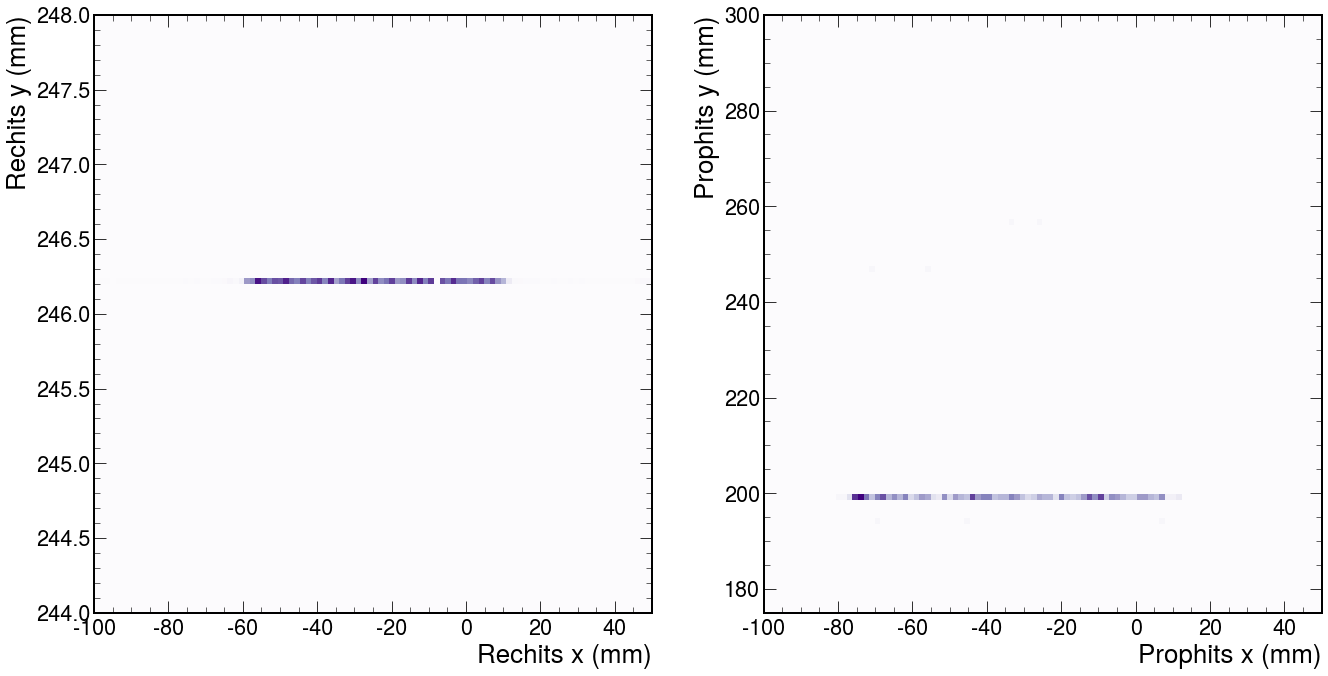

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,11))
_ = ax[0].hist2d(
    ak.flatten(rechits_x_chamber), ak.flatten(rechits_y_chamber),
    bins=(100,100), range=((-100,50),(244,248))
)
_ = ax[1].hist2d(
    ak.flatten(prophits_x_chamber), ak.flatten(prophits_y_chamber),
    bins=(100,100), range=((-100,50),(175,300))
)
ax[0].set_xlabel("Rechits x (mm)")
ax[0].set_ylabel("Rechits y (mm)")
ax[1].set_xlabel("Prophits x (mm)")
ax[1].set_ylabel("Prophits y (mm)")

In [109]:
# choose only events with both a prophit and a rechit and broadcast the prophits
residual_filter = (ak.count(rechits_x_chamber, axis=1)>0)&(ak.count(prophits_x_chamber, axis=1)>0)

rechits_x_broadcast, prophits_x_broadcast = ak.broadcast_arrays(
    rechits_x_chamber[residual_filter],
    ak.flatten(prophits_x_chamber[residual_filter])
)
print("Rechits x:", rechits_x_broadcast)
print("Prophits x:", prophits_x_broadcast)

residual_filter = (ak.count(rechits_y_chamber, axis=1)>0)&(ak.count(prophits_y_chamber, axis=1)>0)
rechits_y_broadcast, prophits_y_broadcast = ak.broadcast_arrays(
    rechits_y_chamber[residual_filter],
    ak.flatten(prophits_y_chamber[residual_filter])
)
print("Rechits y:", rechits_y_broadcast)
print("Prophits y:", prophits_y_broadcast)

residuals_y = rechits_y_broadcast-prophits_y_broadcast
residuals_x = rechits_x_broadcast-prophits_x_broadcast

rechits_r_broadcast, prophits_r_broadcast = ak.broadcast_arrays(
    rechits_r_chamber[residual_filter],
    ak.flatten(prophits_r_chamber[residual_filter])
)
rechits_phi_broadcast, prophits_phi_broadcast = ak.broadcast_arrays(
    rechits_phi_chamber[residual_filter],
    ak.flatten(prophits_phi_chamber[residual_filter])
)
rechits_cluster_size_broadcast, prophits_phi_broadcast = ak.broadcast_arrays(
    rechits_phi_chamber[residual_filter],
    ak.flatten(prophits_phi_chamber[residual_filter])
)
residuals_polar = prophits_r_broadcast * (rechits_phi_broadcast - prophits_phi_broadcast)
residuals_phi = rechits_phi_broadcast - prophits_phi_broadcast

Rechits x: [[-6.22], [7.56], [-5.78], [-52.9], ... [2.67], [-30.2, -28.4], [1.33], [-31.6]]
Prophits x: [[-9.09], [9.64], [-7.67], [-67.2], ... [2.8], [-38.3, -38.3], [1.74], [-40.7]]
Rechits y: [[246], [246], [246], [246], [246], [246, ... [246], [246], [246, 246], [246], [246]]
Prophits y: [[557], [613], [593], [578], [627], [582, ... [629], [606], [631, 631], [616], [587]]


[ 2.48295474e-02 -1.78909847e-05]
[2.19216137e-02 3.65033938e-05]
m =  -1.7890984720344626e-05 +- 3.65033938206181e-05
theta =  -1.7890984721299073e-05 +- 3.650339382646023e-05


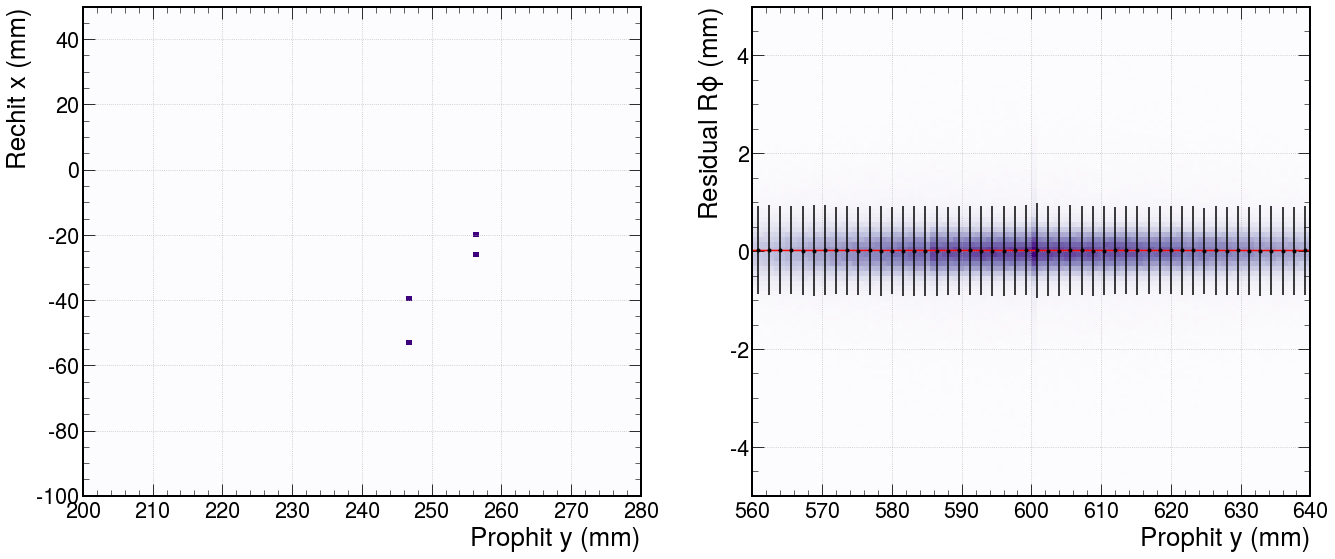

In [110]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22,9))

b = (100,100)
range_rechits = ((200,280),(-100,50))
range_residuals = ((560,640),(-5,5))
_ = ax[0].hist2d(
    ak.flatten(prophits_y_broadcast), ak.flatten(rechits_x_broadcast),
    bins=b, range=range_rechits
)
ax[0].grid()
ax[0].set_xlabel("Prophit y (mm)")
ax[0].set_ylabel("Rechit x (mm)")

prophits = prophits_y_broadcast
_ = ax[1].hist2d(
    ak.flatten(prophits), ak.flatten(residuals_polar),
    range=range_residuals, bins=b
)
mask_infinite = np.isfinite(prophits)&np.isfinite(residuals_polar)
mask_infinite = mask_infinite&(abs(residuals_polar)<5)
mask_infinite = mask_infinite&(prophits>range_residuals[0][0])&(prophits<range_residuals[0][1])
residuals_means, prophits_edges, _ = binned_statistic(
    ak.flatten(prophits[mask_infinite]), ak.flatten(residuals_polar[mask_infinite]),
    statistic="mean", range=range_residuals[0], bins=50
)
residuals_std, prophits_edges, _ = binned_statistic(
    ak.flatten(prophits[mask_infinite]), ak.flatten(residuals_polar[mask_infinite]),
    statistic="std", range=range_residuals[0], bins=50
)
prophits_centers = 0.5*(prophits_edges[1:]+prophits_edges[:-1])
_ = ax[1].errorbar(prophits_centers, residuals_means, yerr=residuals_std, fmt=".k")
ax[1].set_xlabel("Prophit y (mm)")
ax[1].set_ylabel("Residual R$\phi$ (mm)")
ax[1].grid()

popt = [0,1]
lin = lambda x, A, B: A+B*x
popt, pcov = curve_fit(lin, prophits_centers, residuals_means, sigma=residuals_std)
perr = np.sqrt(np.diag(pcov))
print(popt)
xs = np.linspace(range_residuals[0][0], range_residuals[0][1], 50)
_ = ax[1].plot(xs, lin(xs, *popt), "-", color="red")
theta = np.arcsin(popt[1])
print(perr)
err_theta = perr[1]/np.sqrt(1-popt[1]**2)
print("m = ", popt[1], "+-", perr[1])
print("theta = ", theta, "+-", err_theta)

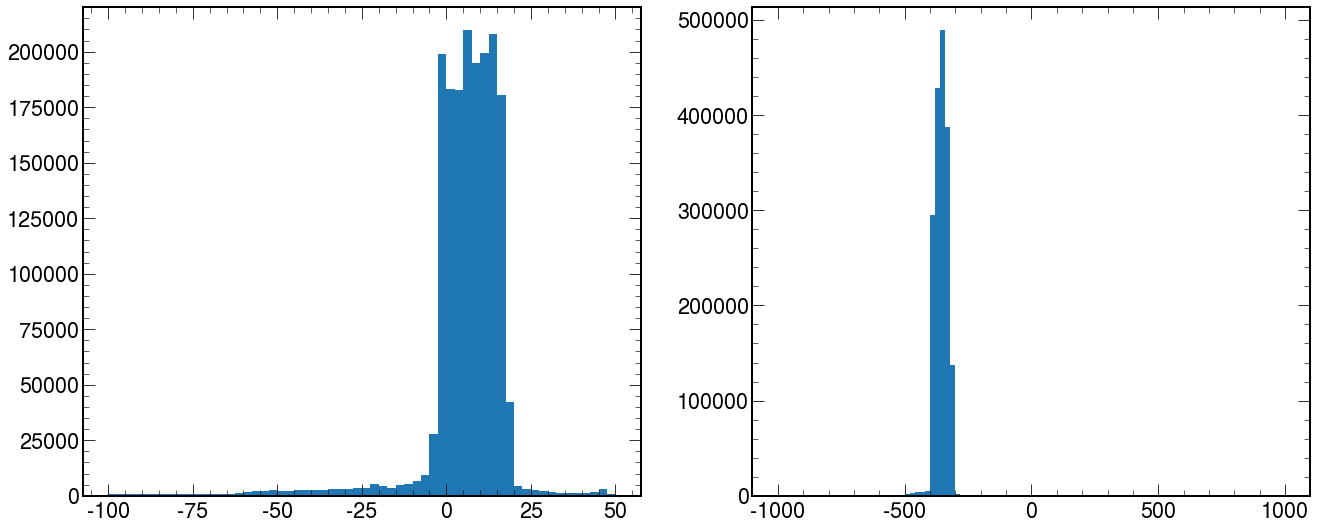

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,9))
_ = ax[0].hist(ak.min(residuals_x, axis=1), bins=60, range=(-100,50))
_ = ax[1].hist(ak.min(residuals_y, axis=1), bins=100, range=(-1000,1000))

[8.54628465e-05 1.35963017e+05 3.67846139e-01]
Correction x 8.546284653258562e-05 ± 0.0042171444648362155 mm
Resolution x 0.3678461387878337 ± 0.004217125074524411 mm


Text(0.05, 0.9, 'Mean 0.00 $\\pm$ 0.00 mm\nSigma 367.85 $\\pm$ 4.22 µm\n')

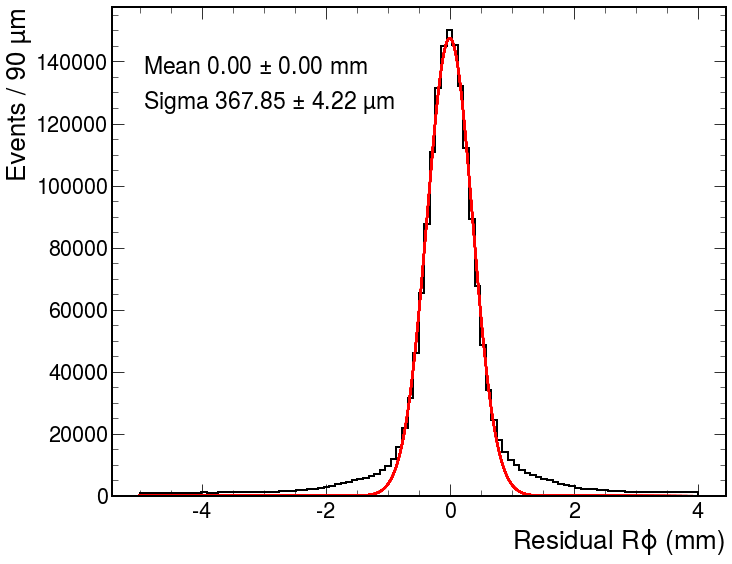

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,9))
residuals_polar_flat = ak.flatten(residuals_polar, axis=1).to_numpy()
polar_values, polar_edges, _ = ax.hist(
    residuals_polar_flat,
    bins=100, range=(-5,4),
    histtype="step", linewidth=2, color="k"
)
polar_centers = 0.5*(polar_edges[1:]+polar_edges[:-1])

popt = [ residuals_polar_flat.mean(), residuals_polar_flat.max(), residuals_polar_flat.std() ]
#popt += [ delta_t.mean(), delta_t.max(), delta_t.std() ]
popt, pcov = curve_fit(gauss_pdf, polar_centers, polar_values)
perr = np.sqrt(np.diag(pcov))
print(popt)
x_correction, x_resolution = popt[0], popt[2]
err_x_correction, err_x_resolution = perr[0], perr[2]
print("Correction x", x_correction, "±", err_x_correction, "mm")
print("Resolution x", x_resolution, "±", err_x_resolution, "mm")
perr = np.sqrt(np.diag(pcov))

x = np.linspace(polar_edges[0], polar_edges[:-1], 1000)
_ = ax.plot(x, gauss_pdf(x, *popt), linewidth=2, color="red")

binning = np.diff(polar_edges).mean()
ax.set_xlabel("Residual R$\phi$ (mm)")
ax.set_ylabel(f"Events / {binning*1e3:1.0f} µm")

ax.text(
    0.05, 0.9,
    f"Mean {x_correction:1.2f} $\pm$ {err_x_correction:1.2f} mm\n"+\
    f"Sigma {x_resolution*1e3:1.2f} $\pm$ {err_x_resolution*1e3:1.2f} µm\n",
    transform = ax.transAxes, ha="left", va="top",
    fontsize=23, linespacing=1.5
)

[ 0.11159108 -0.08795046 -0.00111781 -0.08080544 -0.02492893 -0.05681146
  0.36018319  0.31925808  0.01213851 -0.35948365 -0.55831026  0.12850056
  0.21653462  0.0727017   0.15091799  0.14561343  0.05053752  0.09483306
  0.00400054 -0.38065482]
[2.68653826 2.69473796 2.93849188 2.90927633 3.1786293  2.98067656
 3.8627651  3.44242287 3.21793084 3.51636128 4.095643   3.03000853
 2.69204575 2.65328574 3.32082076 2.781991   2.86716754 2.64374313
 2.54558801 3.45545784]
[0.02561621 0.16223931]
y correction -0.16223930950830312 ± 2.414382167009739 mm


Text(0, 1, 'Polar residual R$\\phi$ (mm)')

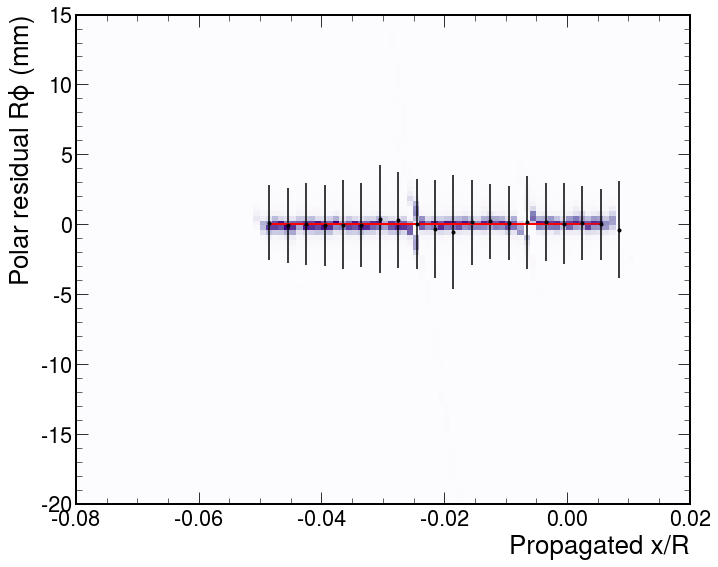

In [113]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(11,9))

b = (100,100)
_ = ax.hist2d(
    ak.flatten(prophits_x_broadcast / prophits_r_broadcast), ak.flatten(residuals_polar),
    bins=b, range=((-0.08,0.02),(-20,15))
)
x_over_r = prophits_x_broadcast / prophits_r_broadcast
mask_infinite = np.isfinite(x_over_r)
mask_infinite = mask_infinite&(np.isfinite(residuals_polar))
mask_infinite = mask_infinite&(abs(residuals_polar)<20)
residuals_means, x_r_edges, _ = binned_statistic(
    ak.flatten(x_over_r[mask_infinite]),
    ak.flatten(residuals_polar[mask_infinite]),
    statistic="mean", bins=20, range=(-0.05,0.01)
)
residuals_std, x_r_edges, _ = binned_statistic(
    ak.flatten(x_over_r[mask_infinite]),
    ak.flatten(residuals_polar[mask_infinite]),
    statistic="std", bins=20, range=(-0.05,0.01)
)
print(residuals_means)
print(residuals_std)
x_r_centers = 0.5*(x_r_edges[1:]+x_r_edges[:-1])
ax.errorbar(x_r_centers, residuals_means, yerr=residuals_std, fmt=".k")

popt = [0,1]
lin = lambda x, A, B: A+B*x
popt, pcov = curve_fit(lin, x_r_centers, residuals_means, sigma=residuals_std)
perr = np.sqrt(np.diag(pcov))
print(popt)
xs = np.linspace(x_r_centers[0], x_r_centers[:-1], 50)
_ = ax.plot(xs, lin(xs, *popt), "-", color="red")
delta_y = -popt[1]
err_y = perr[1]
print("y correction", delta_y, "±", err_y, "mm")

ax.set_xlabel("Propagated x/R")
ax.set_ylabel("Polar residual R$\phi$ (mm)")

Correction phi -0.001436788980529653 ± 0.0022136205104703014 mrad
Resolution phi 0.23504616198687567 ± 0.002213620779180774 mrad


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


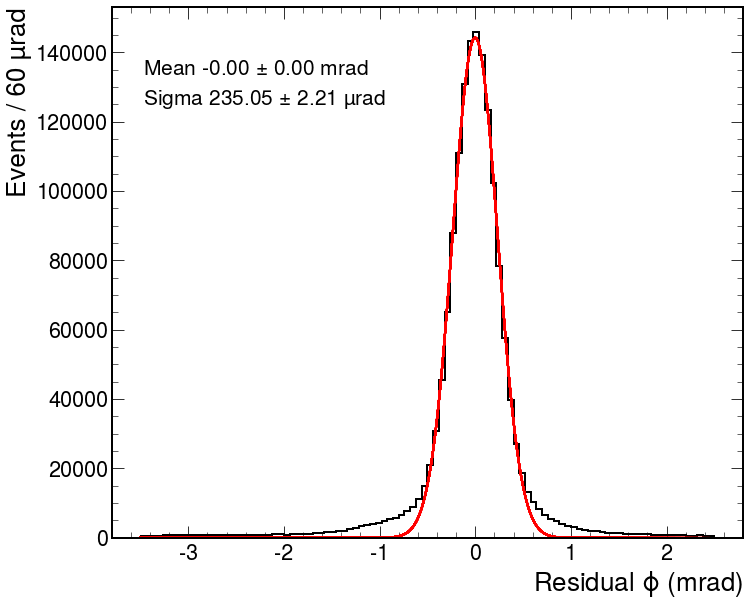

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,9))
residuals_phi_flat = ak.min(residuals_phi, axis=1).to_numpy()*1e3
polar_values, polar_edges, _ = ax.hist(
    residuals_phi_flat,
    bins=100, range=(-3.5,2.5),
    histtype="step", linewidth=2, color="k"
)
polar_centers = 0.5*(polar_edges[1:]+polar_edges[:-1])

popt = [ np.mean(residuals_phi), ak.count(residuals_phi), np.std(residuals_phi) ]
#popt += [ delta_t.mean(), delta_t.max(), delta_t.std() ]
popt, pcov = curve_fit(gauss_pdf, polar_centers, polar_values)
perr = np.sqrt(np.diag(pcov))
phi_correction, phi_resolution = popt[0], popt[2]
err_phi_correction, err_phi_resolution = perr[0], perr[2]
print("Correction phi", phi_correction, "±", err_phi_correction, "mrad")
print("Resolution phi", phi_resolution, "±", err_phi_resolution, "mrad")
perr = np.sqrt(np.diag(pcov))

phi = np.linspace(polar_edges[0], polar_edges[:-1], 500)
_ = ax.plot(phi, gauss_pdf(phi, *popt), linewidth=2, color="red")

binning = np.diff(polar_edges).mean()
ax.set_xlabel("Residual $\phi$ (mrad)")
ax.set_ylabel(f"Events / {binning*1e3:1.0f} µrad")

ax.text(
    0.05, 0.9,
    f"Mean {phi_correction:1.2f} $\pm$ {err_phi_correction:1.2f} mrad\n"+\
    f"Sigma {phi_resolution*1e3:1.2f} $\pm$ {err_phi_resolution*1e3:1.2f} µrad\n",
    transform = ax.transAxes, ha="left", va="top",
    fontsize=21, linespacing=1.5
)
fig.tight_layout()
fig.savefig("me0_residuals.pdf")

[[0.000823], [0.000165], [0.000132], ... [-0.0011], [7.1e-06], [5.93e-05]]


Text(0, 1, 'Number of hits')

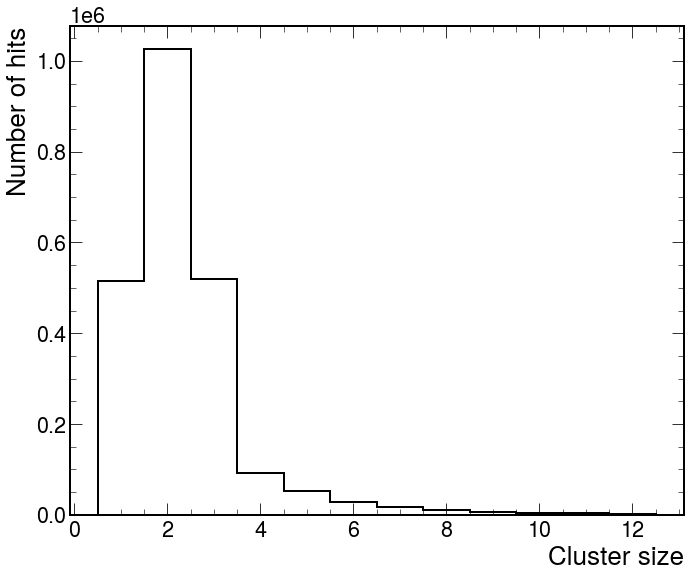

In [115]:
residuals_index = ak.argmin(residuals_phi, axis=1, keepdims=True)
residuals_phi_min = residuals_phi[residuals_index]
residuals_cluster_size = rechits_cluster_size_chamber[residual_filter][residuals_index]
print(residuals_phi_min)

fig, ax = plt.subplots(figsize=(11,9))
_ = ax.hist(
    ak.flatten(rechits_cluster_size_chamber),
    bins=12, range=(0.5,12.5),
    linewidth=2, histtype="step", color="k"
)
ax.set_xlabel("Cluster size")
ax.set_ylabel("Number of hits")

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


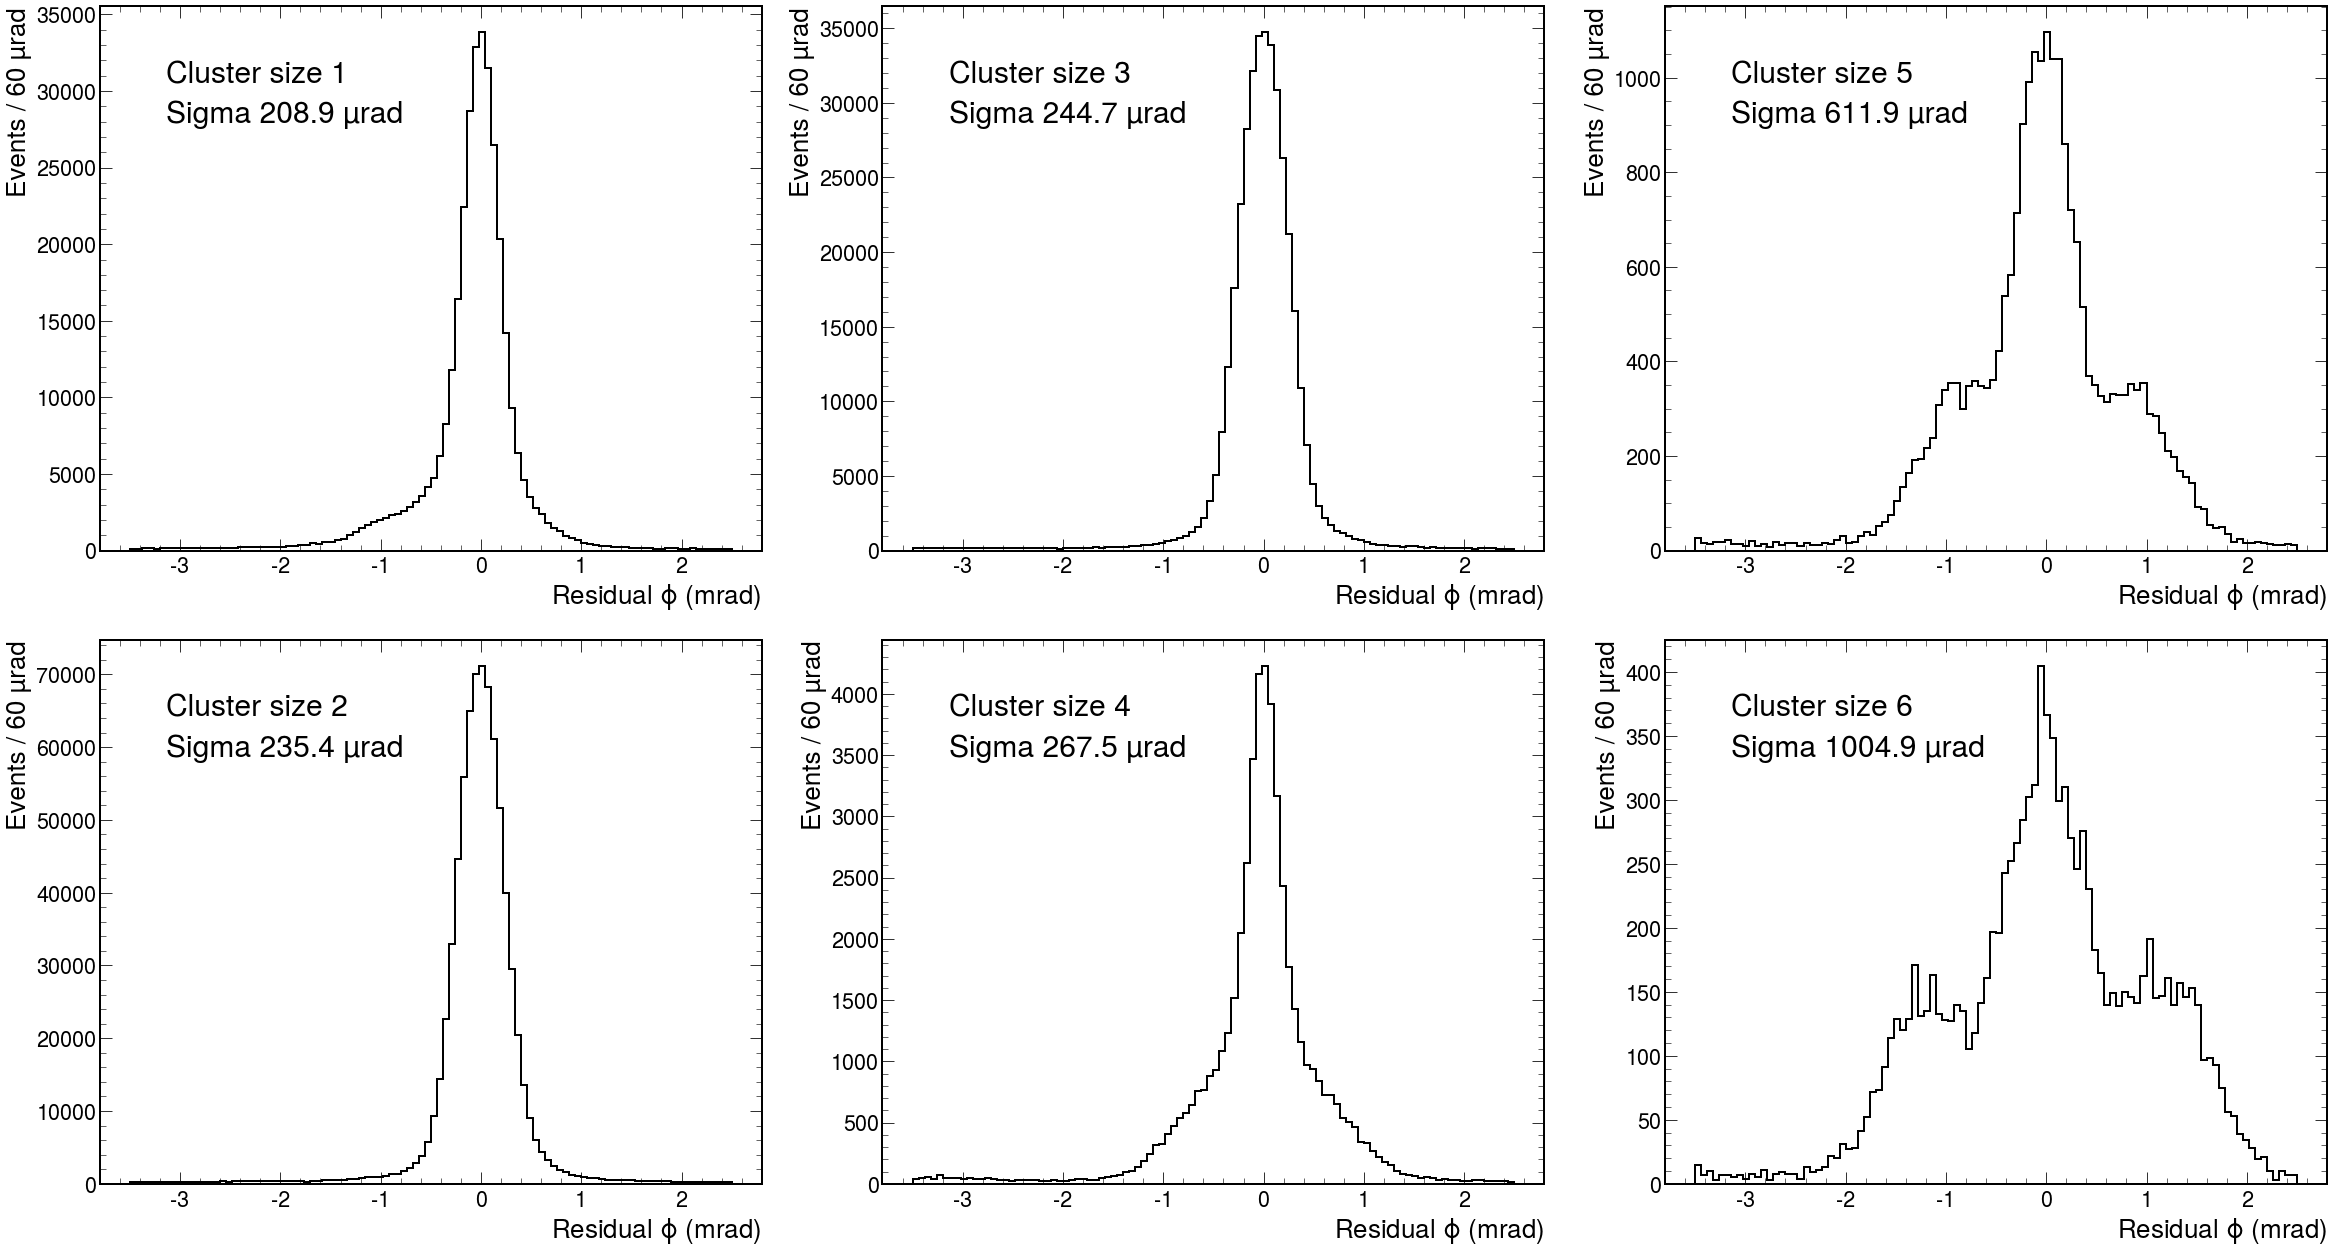

In [124]:
max_cluster_size = 6
ncols, nrows = int(max_cluster_size*0.5), 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11*ncols,9*nrows))

for cluster_size in range(1, max_cluster_size+1):
    residuals_subset = ak.flatten(residuals_phi_min[residuals_cluster_size==cluster_size])
    residuals_subset_range=(-3.5,2.5)
    irow, icol = (cluster_size-1)%2, int((cluster_size-1)/2)
    ax = axs[irow][icol]
    polar_values, polar_edges, _ = ax.hist(
        residuals_subset*1e3,
        bins=100, range=residuals_subset_range,
        histtype="step", linewidth=2, color="k"
    )
    polar_centers = 0.5*(polar_edges[1:]+polar_edges[:-1])
    
    popt = [ np.mean(residuals_phi), ak.count(residuals_phi), np.std(residuals_phi) ]
    #popt += [ delta_t.mean(), delta_t.max(), delta_t.std() ]
    popt, pcov = curve_fit(gauss_pdf, polar_centers, polar_values)
    perr = np.sqrt(np.diag(pcov))
    phi_correction, phi_resolution = popt[0], popt[2]
    err_phi_correction, err_phi_resolution = perr[0], perr[2]
    #print("Correction phi", phi_correction, "±", err_phi_correction, "mrad")
    #print("Resolution phi", phi_resolution, "±", err_phi_resolution, "mrad")
    #phi = np.linspace(polar_edges[0], polar_edges[:-1], 500)
    #_ = ax.plot(phi, gauss_pdf(phi, *popt), linewidth=2, color="red")
    
    ax.text(
        0.1, 0.9,
        f"Cluster size {cluster_size}\n"+\
        f"Sigma {phi_resolution*1e3:1.1f} µrad",
        transform = ax.transAxes,
        ha="left", va="top",
        fontsize=30, linespacing=1.5
    )
    ax.set_xlabel("Residual $\phi$ (mrad)")
    ax.set_ylabel(f"Events / {np.diff(polar_edges).mean()*1e3:1.0f} µrad")

fig.tight_layout()
fig.savefig("me0_residuals_cls.pdf")

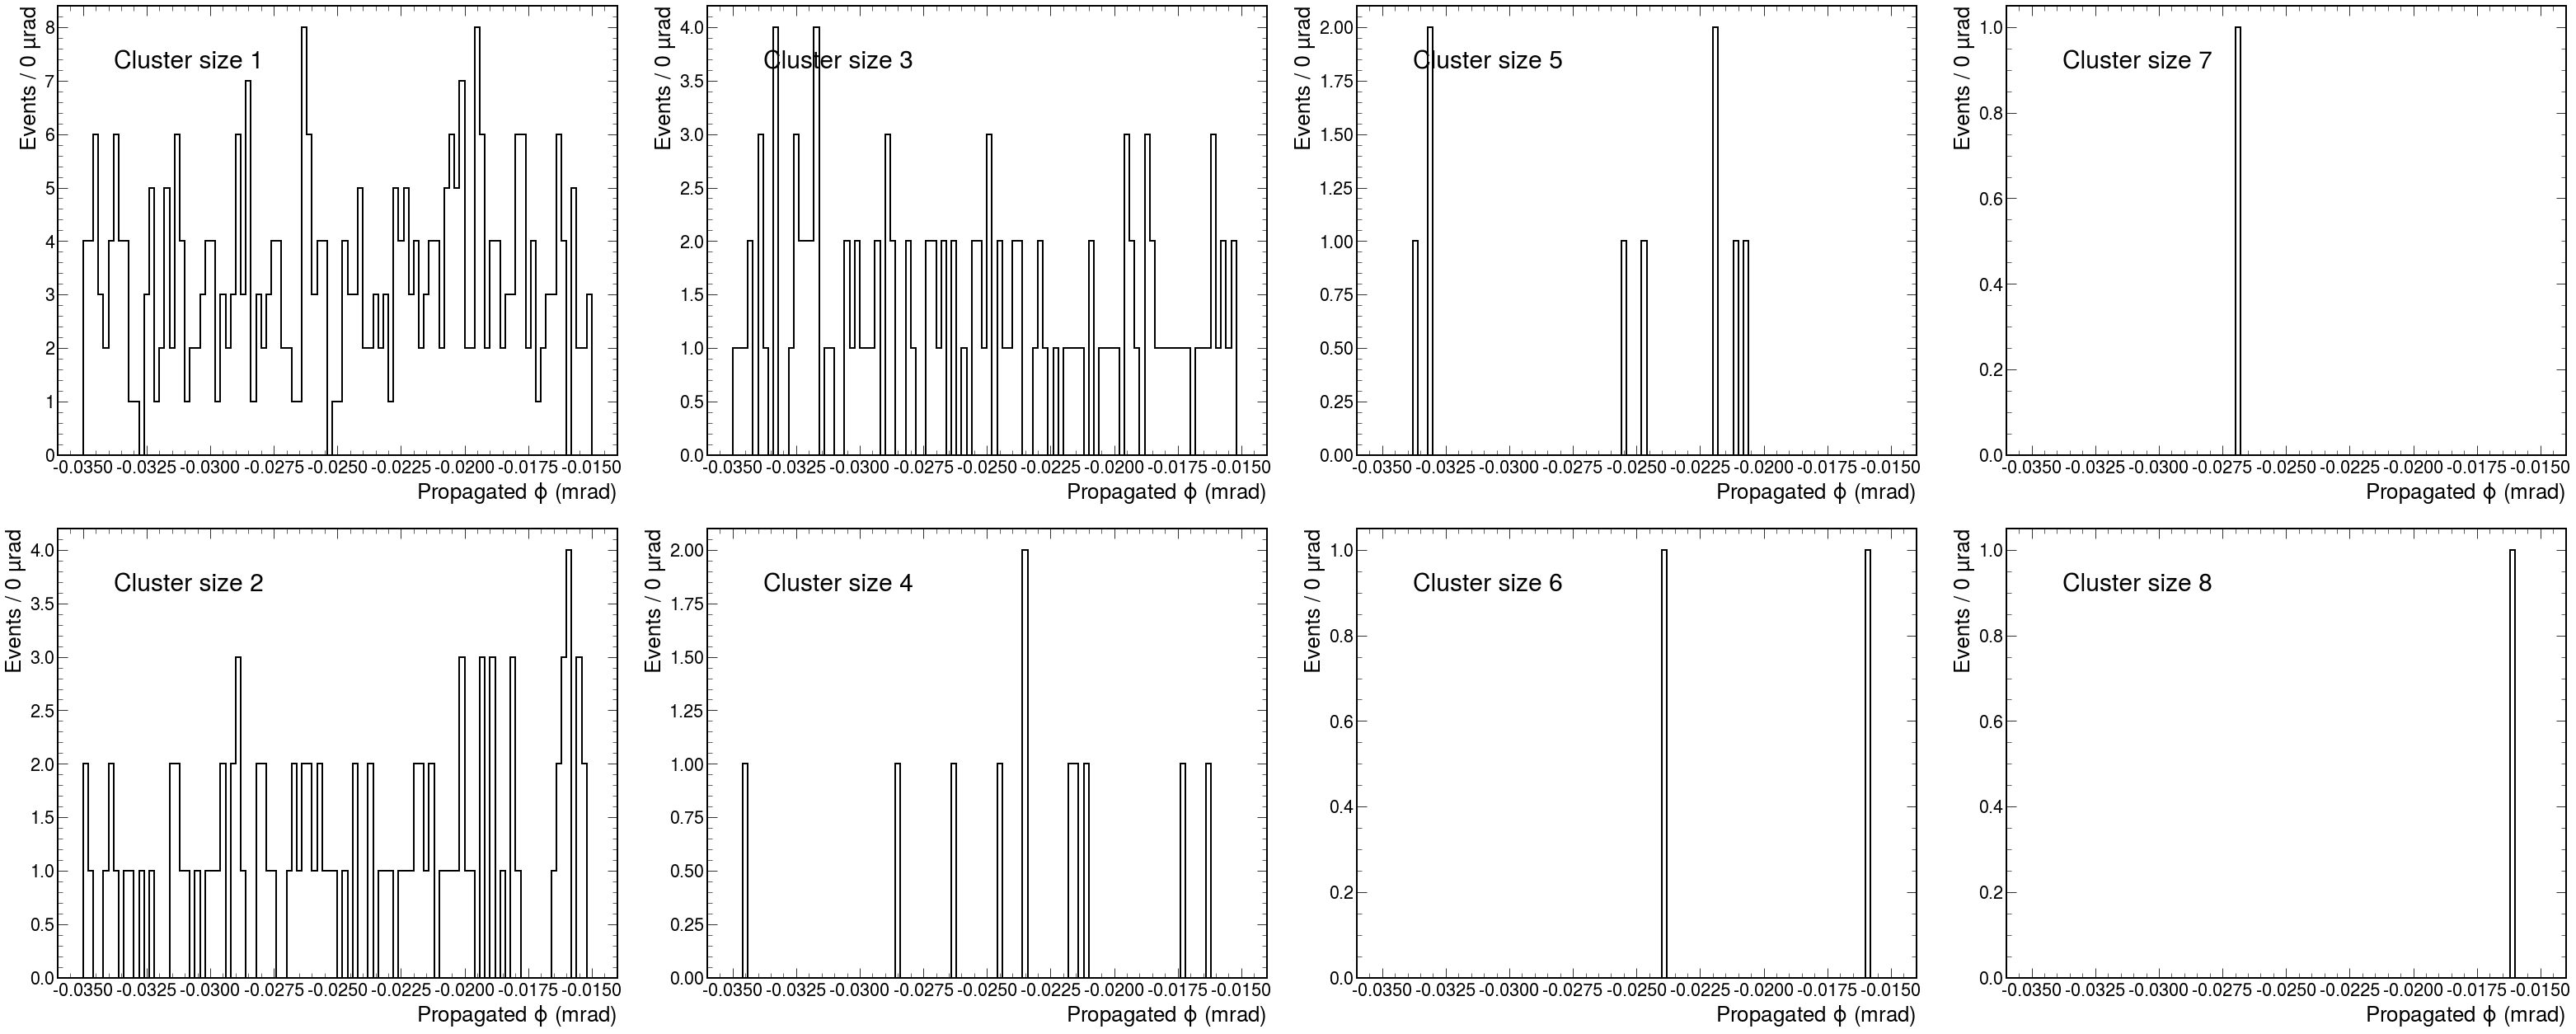

In [22]:
max_cluster_size = 8
ncols, nrows = int(max_cluster_size*0.5), 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11*ncols,9*nrows))

for cluster_size in range(1, max_cluster_size+1):
    residuals_index = ak.argmin(residuals_phi, axis=1, keepdims=True)
    prophits_phi_min = prophits_phi_broadcast[residuals_index]
    prophits_subset = ak.flatten(prophits_phi_min[residuals_cluster_size==cluster_size])
    irow, icol = (cluster_size-1)%2, int((cluster_size-1)/2)
    ax = axs[irow][icol]
    prophit_values, prophit_edges, _ = ax.hist(
        prophits_subset*1e3,
        bins=100, range=(-0.025-0.01,-0.025+0.01),
        histtype="step", linewidth=2, color="k"
    )
    prophit_centers = 0.5*(polar_edges[1:]+polar_edges[:-1])
    
    ax.text(
        0.1, 0.9,
        f"Cluster size {cluster_size}\n",
        transform = ax.transAxes,
        ha="left", va="top",
        fontsize=30
    )
    ax.set_xlabel("Propagated $\phi$ (mrad)")
    ax.set_ylabel(f"Events / {np.diff(prophit_edges).mean()*1e3:1.0f} µrad")

fig.tight_layout()